<a href="https://colab.research.google.com/github/Yogs05/Task/blob/main/TugasTK1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tugas Individu Akhir Citra Digital TK1**

Nama : Prayoga Permana

NPM : 2206030621

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os

#### **Eksplorasi Data**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("loki4514/rice-leaf-diseases-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-leaf-diseases-detection


In [ ]:
folder_path= path + "/Rice_Leaf_AUG/Rice_Leaf_AUG"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32)

Found 11790 files belonging to 9 classes.


In [ ]:
from collections import Counter

# Path ke direktori utama dataset
root_dir = folder_path
# List semua folder (class) di dalam root_dir
class_counts = {}

for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images


# Tampilkan jumlah gambar per kelas
for class_name, count in sorted(class_counts.items()):
    print(f"{class_name:30s}: {count} gambar")



Bacterial Leaf Blight         : 1197 gambar
Brown Spot                    : 1546 gambar
Healthy Rice Leaf             : 1085 gambar
Leaf Blast                    : 1748 gambar
Leaf scald                    : 1332 gambar
Narrow Brown Leaf Spot        : 954 gambar
Neck_Blast                    : 1000 gambar
Rice Hispa                    : 1299 gambar
Sheath Blight                 : 1629 gambar


<ipython-input-5-8b30f9c6062f>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x="Class", y="Count", palette="viridis")


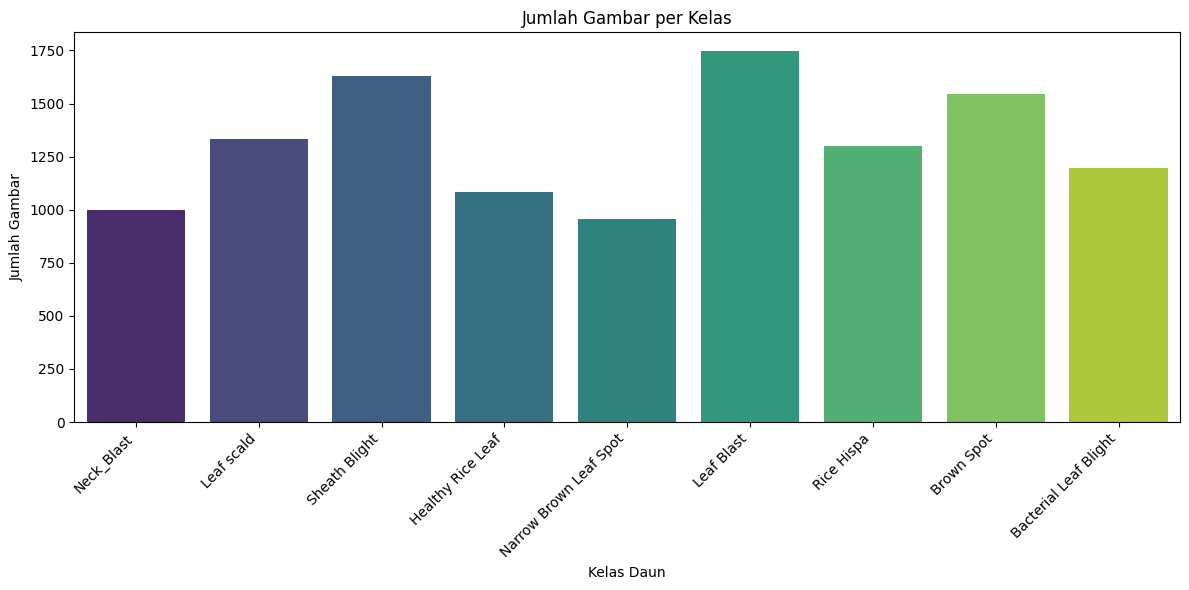

In [ ]:
import seaborn as sns
import pandas as pd

# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Konversi ke DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x="Class", y="Count", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Jumlah Gambar per Kelas")
plt.xlabel("Kelas Daun")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()


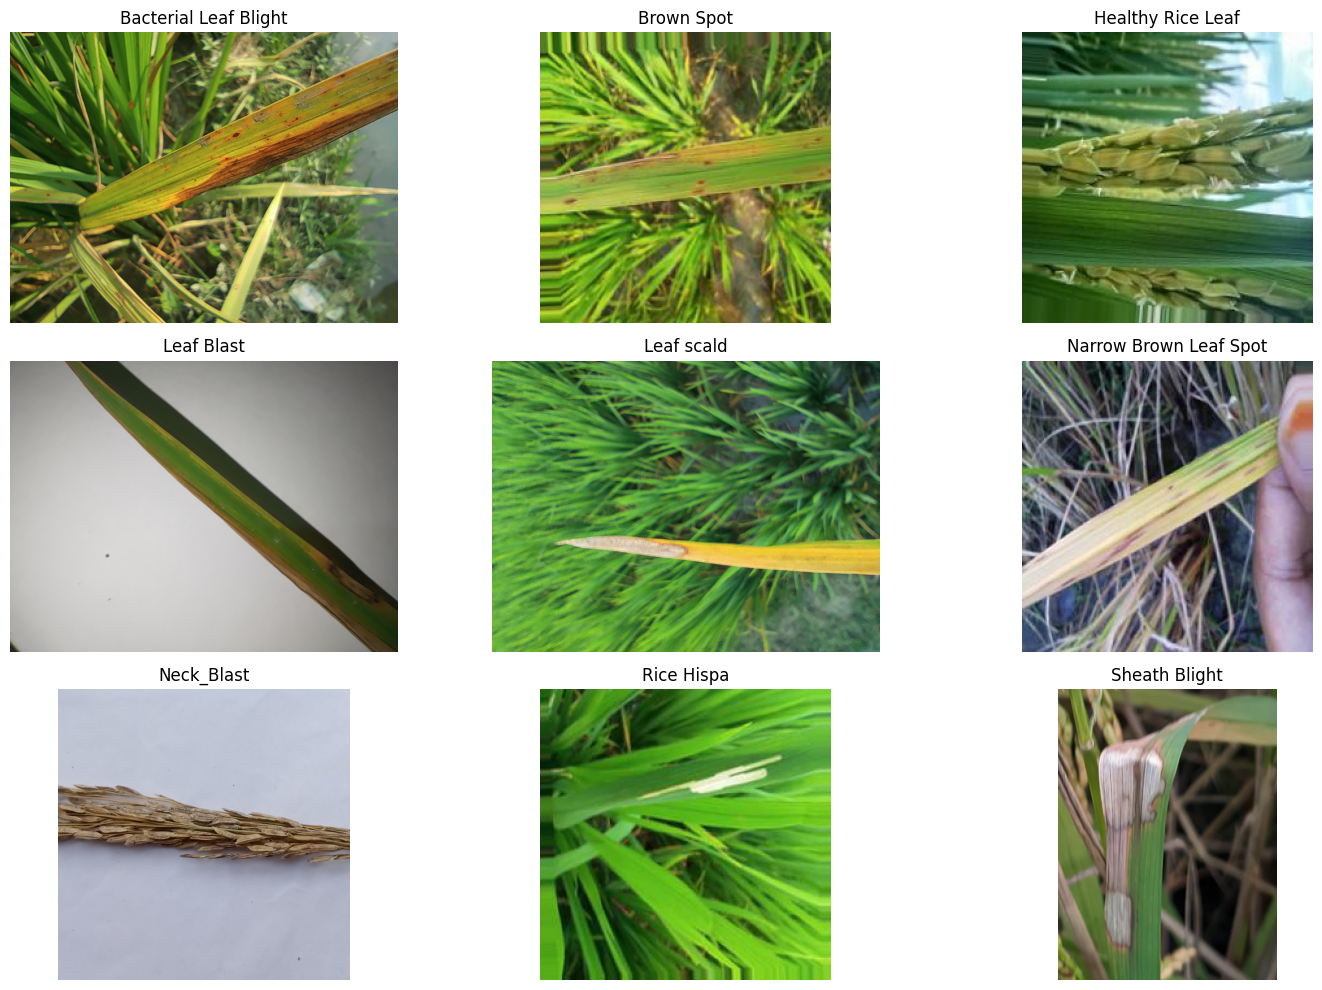

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Inisialisasi figure
plt.figure(figsize=(15, 10))

# Ambil satu gambar dari setiap kelas
for i, class_name in enumerate(sorted(os.listdir(root_dir))):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        # Ambil nama file pertama di folder kelas
        first_image = os.listdir(class_path)[0]
        image_path = os.path.join(class_path, first_image)

        # Baca dan tampilkan gambar
        img = mpimg.imread(image_path)
        plt.subplot(3, 3, i + 1)  # Ubah 3,3 sesuai jumlah kelas
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


#### **Data Splitting**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),  # sesuai dengan input MobileNetV2
    batch_size=32,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 11790 files belonging to 9 classes.
Using 9432 files for training.
Found 11790 files belonging to 9 classes.
Using 2358 files for validation.


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Rescaling

# Terapkan preprocessing sesuai MobileNetV2
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

class_names = [class_name for class_name in train_ds]
num_classes = len(class_names)

# Load pretrained MobileNetV2 tanpa top layer
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # untuk transfer learning awal

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 295)            │        38,055 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,007 (9.38 MB)

 Trainable params: 202,023 (789.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### **Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Latih model dengan early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 64s 185ms/step - accuracy: 0.4087 - loss: 2.1276 - val_accuracy: 0.7108 - val_loss: 0.8366
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.6902 - loss: 0.8928 - val_accuracy: 0.7807 - val_loss: 0.6521
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7435 - loss: 0.7267 - val_accuracy: 0.7956 - val_loss: 0.5644
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7721 - loss: 0.6481 - val_accuracy: 0.8159 - val_loss: 0.5120
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8112 - loss: 0.5417 - val_accuracy: 0.8435 - val_loss: 0.4510
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8288 - loss: 0.4901 - val_accuracy: 0.8499 - val_loss: 0.4324
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8430 - loss: 0.4522 - val_accuracy: 0.8634 - val_loss: 0.3742
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8620 - loss: 0.3884 - va

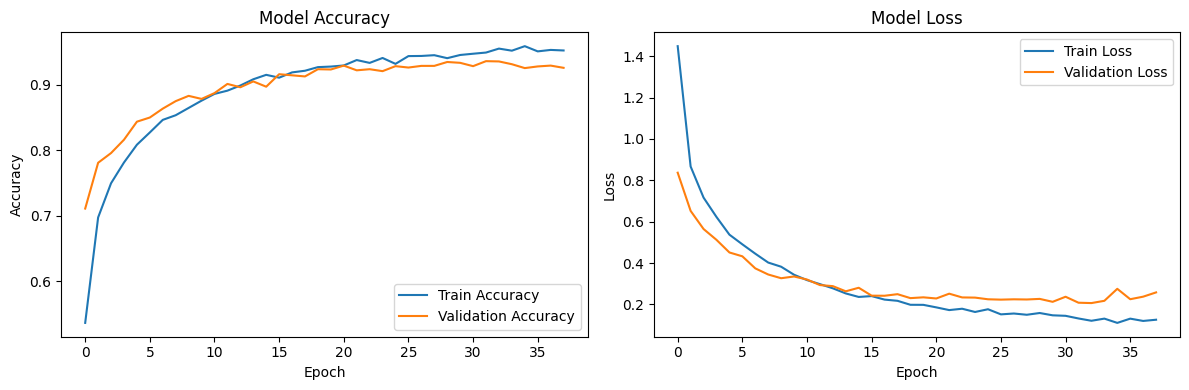

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### **Model Evaluasi**

Classification Report

Found 11790 files belonging to 9 classes.
Using 2358 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━

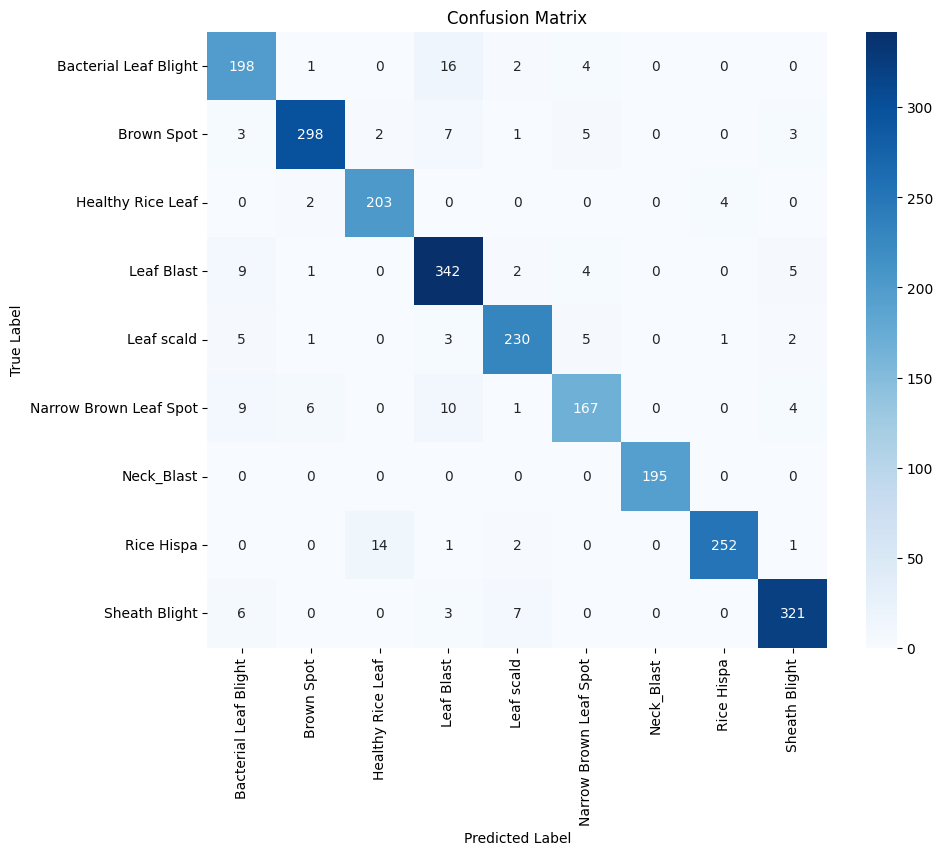

Classification Report:

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.86      0.90      0.88       221
            Brown Spot       0.96      0.93      0.95       319
     Healthy Rice Leaf       0.93      0.97      0.95       209
            Leaf Blast       0.90      0.94      0.92       363
            Leaf scald       0.94      0.93      0.93       247
Narrow Brown Leaf Spot       0.90      0.85      0.87       197
            Neck_Blast       1.00      1.00      1.00       195
            Rice Hispa       0.98      0.93      0.96       270
         Sheath Blight       0.96      0.95      0.95       337

              accuracy                           0.94      2358
             macro avg       0.94      0.93      0.93      2358
          weighted avg       0.94      0.94      0.94      2358



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Simpan class_names sebelum .map()
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

class_names = raw_val_ds.class_names


# Prediksi dan label aktual
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)


In [ ]:
model.save('model_TUGAS_TK1.h5')

#### **Contoh Penggunaan Model**

In [ ]:
!pip install gdown
import gdown

In [ ]:
file_id = "1OcMAmqihI_sWZ5S-rp55vYFQQEzQJiiG"
url = f"https://drive.google.com/uc?id={file_id}"
output_path = "gambar_Sheath_blight.jpg"
gdown.download(url, output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1OcMAmqihI_sWZ5S-rp55vYFQQEzQJiiG
To: /content/gambar_Sheath_blight.jpg
100%|██████████| 100k/100k [00:00<00:00, 3.15MB/s]


'gambar_Sheath_blight.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class: Sheath Blight


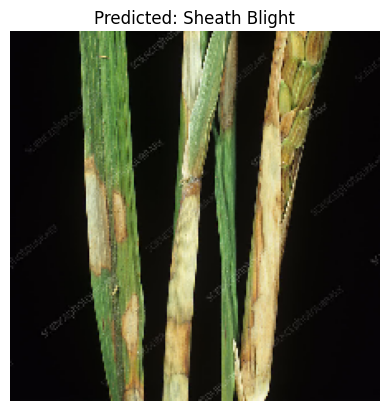

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load dan preprocess gambar
img = image.load_img(output_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Prediksi
pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)[0]

# Tampilkan hasil
print("Predicted class:", class_names[predicted_class])

plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()
